# Regression

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import math
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns

print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

As with classification, **regression** problems involve predicting a value along a specific feature dimension (sometimes called the "dependent variable") from a set of known values along other feature dimensions.

In regression problems, the value to be predicted is normally a **real number** (e.g., inches of snowfall, income, probability of loan default, expected return on an investment and so on).

Problems where we seek to predict a probability are a special case and can be viewed as a non-discrete form of classification (this is related to logistic regression).

## Prediction and interpretation

Even though regression problems are nominally about __predicting__ a value, they are also often about __explaining__ a relationship, for example: "conditioned on income, does education predict happiness?" But prediction is not the same as explanation.

Success at prediction has the following characteristics:
- it yields a refutable hypothesis (e.g. "$f(x)$ predicts $y$ to within error $\epsilon$ 19 times out of 20 on data of this type");
- it can be evaluated empirically (via a holdout or cross-validation); and
- it does not tell us how we can change outcomes, or about causal relationships.

Success at explanation has the following characteristics:
- does not always yield a refutable hypothesis; 
- cannot always be easily evaluated given data from the same source; and
- when successful, is useful far beyond the immediate problem context.

Many popular regression models exist, e.g.:
- linear regression 
- logistic regression
- neural networks
- "nonparametric" models (basically, arbitrary functions)
- nearest neighbor

In a linear model, the data set consists of vectors and the prediction is a function of a **linear combination** of data set entries. 

That is, we try to find a relationship of the form

$$ y = f\Big(\langle \vec \beta,  \vec x\rangle + \beta_0\Big ) $$ 

for some real number $\beta_0 \in \R$ and vector $\vec\beta \in \R^d$, 

where $f$ is specified (sometimes called the **link function**).

As with classification, linear models are often applied to some transformed version of the data, e.g.
- after projection to a low-dimensional space (via SVD or random projections) and/or
- after transformation to a higher-dimensional space, e.g., via a kernel function. 

As with classification, some algorithms for fitting linear models allow for the "kernel trick".

# Linear Regression

In 1886, Francis Galton published his observations about how random factors affect outliers. This notion has come to be called "regression to the mean" because unusually large or small phenomena, after the influence of random events, become closer to their mean values (less extreme). Galton fit a straight line to this effect, and the fitting of lines or curves to data has come to be called regression, as well.

Fitting a curve to a data set of vectors is equivalent to constructing a function that fits those vectors. **Regression** is the most common form of machine learning and involves constructing an equation that describes the relationships among a collection of variables.

Note that regression is a form of supervised learning. Whereas **classification** deals with predicting categorical features (labels or classes), **regression** deals with predicting continuous features (real values).

For example, we may look at these points and decide to model them using a line.

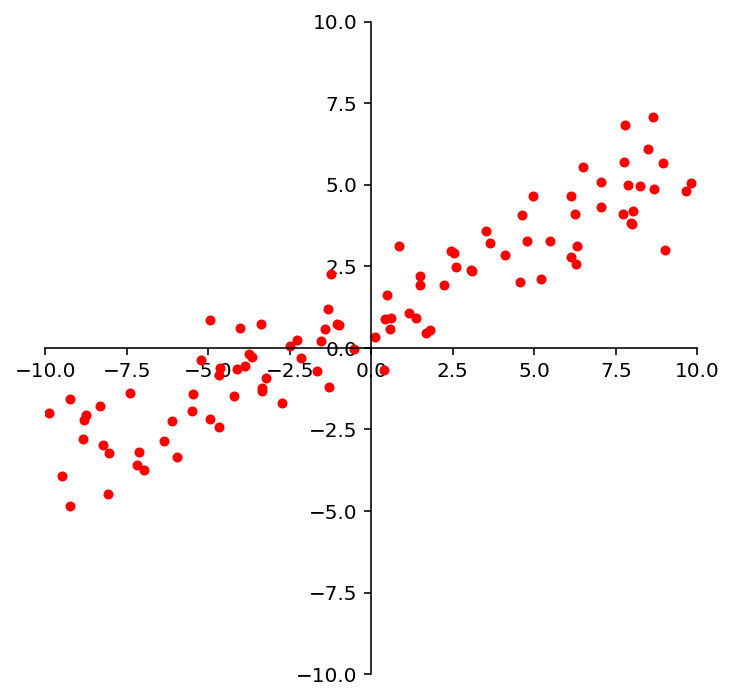

In [3]:
def plotSetup(xmin = -3.0, xmax = 3.0, ymin = -3.0, ymax = 3.0, size=(6,6)):
    """
    refactored version of ut.plotSetup to hide as much as possible when showing code
    basics of 2D plot setup
    defaults: xmin = -3.0, xmax = 3.0, ymin = -3.0, ymax = 3.0, size=(6,6)
    size is by default 6 inches by 6 inches
    """
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1, aspect='equal')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    ax.axes.set_xlim([xmin, xmax])
    centerAxes(ax)
    return ax

def centerAxes (ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    bounds = np.array([ax.axes.get_xlim(), ax.axes.get_ylim()])
    ax.plot(bounds[0][0],bounds[1][0],'')
    ax.plot(bounds[0][1],bounds[1][1],'')
    # ax.plot(bounds, '')

ax = plotSetup(-10,10,-10,10)
centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4);

We may look at these points and decide to model them using a quadratic function.

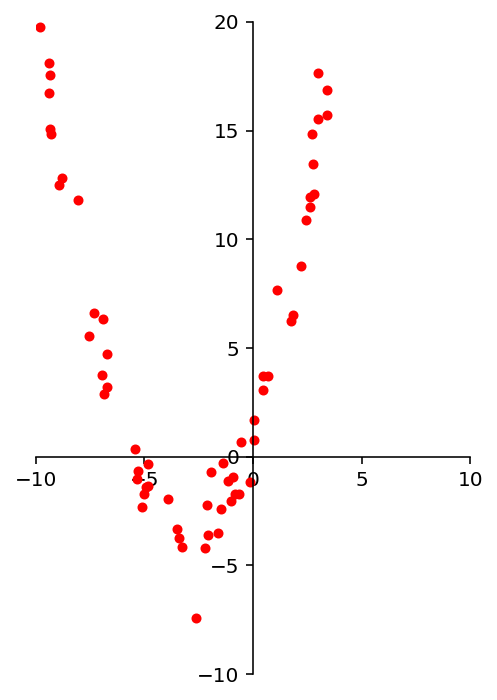

In [5]:
ax = plotSetup(-10,10,-10,20)
centerAxes(ax)
quad = np.array([1, 3, 0.5])
xquad = -10.0 + 20.0 * np.random.random(100)
yquad = quad[0]+(quad[1]*xquad)+(quad[2]*xquad*xquad)+np.random.randn(100)
ax.plot(xquad,yquad,'ro',markersize=4);

And we may look at these points and decide to model them using a logarithmic function.

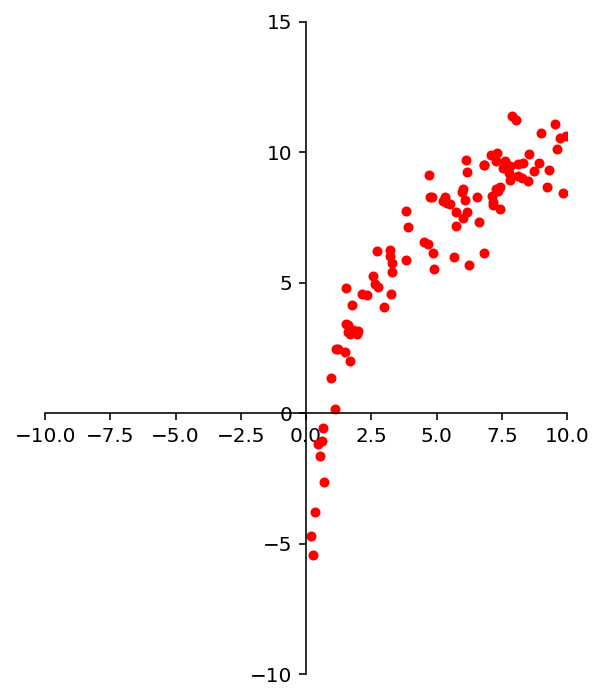

In [6]:
ax = plotSetup(-10,10,-10,15)
centerAxes(ax)
log = np.array([1, 4])
xlog = 10.0 * np.random.random(100)
ylog = log[0]+log[1]*np.log(xlog)+np.random.randn(100)
ax.plot(xlog,ylog,'ro',markersize=4);

Clearly, none of these datasets agrees perfectly with the proposed model. So the question arises: how do we find the **best** linear function (or quadratic function, or logarithmic function) given the data?

This problem has been studied extensively in the field of statistics. We first introduce some terminology:
* __"independent" values__ (a.k.a. "features") are used to predict the
* __"dependent" values__ (a.k.a. "response").

The basic regression task is: 

>given a set of data points, each of which has independent variables and the dependent variables, estimate the parameters of a model (such as a line, parabola, etc.) that predicts the dependent variables from the independent variables.

The independent variables are collected into a matrix $x$, which is called the __design matrix__.

The dependent variables are collected into an **observation** vector $y$.

The parameters of the model (for any kind of model) are collected into a **parameter** vector $\beta$.

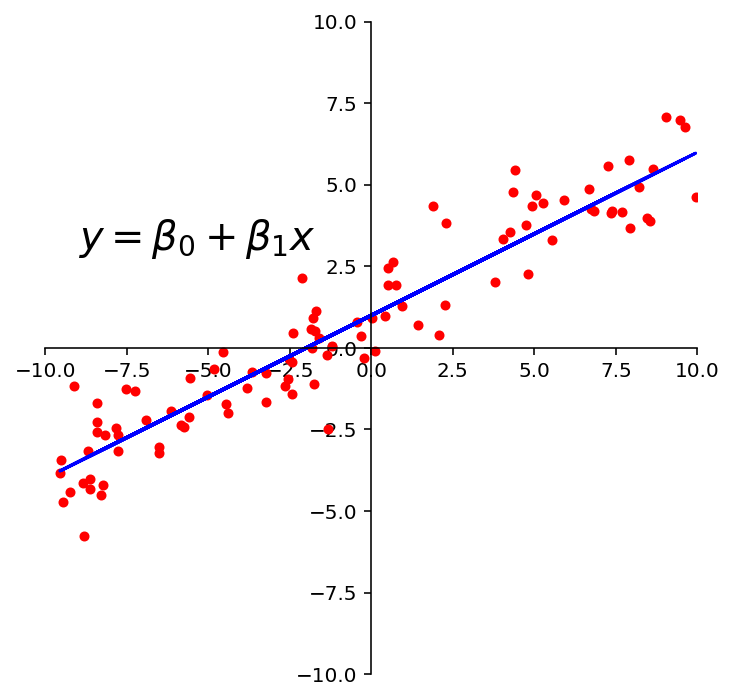

In [7]:
ax = plotSetup(-10,10,-10,10)
centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4)
ax.plot(xlin,line[0]+line[1]*xlin,'b-')
plt.text(-9,3,r'$y = \beta_0 + \beta_1x$',size=20);

## Least-squares

The first kind of model we'll study is a linear equation, $y = \beta_0 + \beta_1 x.$ Experimental data often produce points $(x_1, y_1), \dots, (x_n,y_n)$ that seem to lie close to a line. We want to determine the parameters $\beta_0, \beta_1$ that define a line that is as "close" to the points as possible.

Suppose we have a line $y = \beta_0 + \beta_1 x$.   For each data point $(x_j, y_j),$ there is a point $(x_j, \beta_0 + \beta_1 x_j)$ that is the point on the line with the same $x$-coordinate.

We call $y_j$ the __observed__ value of $y$ and $\beta_0 + \beta_1 x_j$ the __predicted__ $y$-value.   

The difference between an observed $y$-value and a predicted $y$-value is called a __residual__.

There are several ways of measure how "close" the line is to the data. The usual choice is to sum the squares of the residuals.

The __least-squares line__ is the line $y = \beta_0 + \beta_1x$ that minimizes the sum of squares of the residuals.

The coefficients $\beta_0, \beta_1$ of the line are called __regression coefficients__.

__A least-squares problem__

If the data points were on the line, the parameters $\beta_0$ and $\beta_1$ would satisfy the equations

$$\beta_0 + \beta_1 x_1 = y_1 $$
$$\beta_0 + \beta_1 x_2 = y_2 $$
$$\beta_0 + \beta_1 x_3 = y_3 $$
$$ \vdots$$
$$\beta_0 + \beta_1 x_n = y_n $$

We can write this system as 

$$x\vbt = y,\;\;\;\;\mbox{where}\;x=\mat{{cc}1&x_1\\1&x_2\\\vdots&\vdots\\1&x_n},\;\;\vbt = \mat{{c}\beta_0\\\beta_1},\;\;y=\mat{{c}y_1\\y_2\\\vdots\\y_n}$$

Of course, if the data points don't actually lie exactly on a line:

* then there are no parameters $\beta_0, \beta_1$ for which the predicted $y$-values in $x\vbt$ equal the observed values in $y$, and
* the equation $x\vbt=y$ has no solution.

Thus, we are seeking the $\beta$ that minimizes the sum of squared residuals, i.e,

$$\sum_i (\beta_0 + \beta_1 x_i - y_i)^2 = \Vert x\beta - y\Vert^2$$

This is key: __the sum of squares of the residuals__ is **exactly** the __square of the distance between the vectors $x\vbt$ and $y$__.

This is a least-squares problem, often written using the notation $Ax = b$ when studied in linear algebra.

Computing the least-squares solution of $x\beta = y$ is equivalent to finding the $\vbt$ that determines the least-squares line.

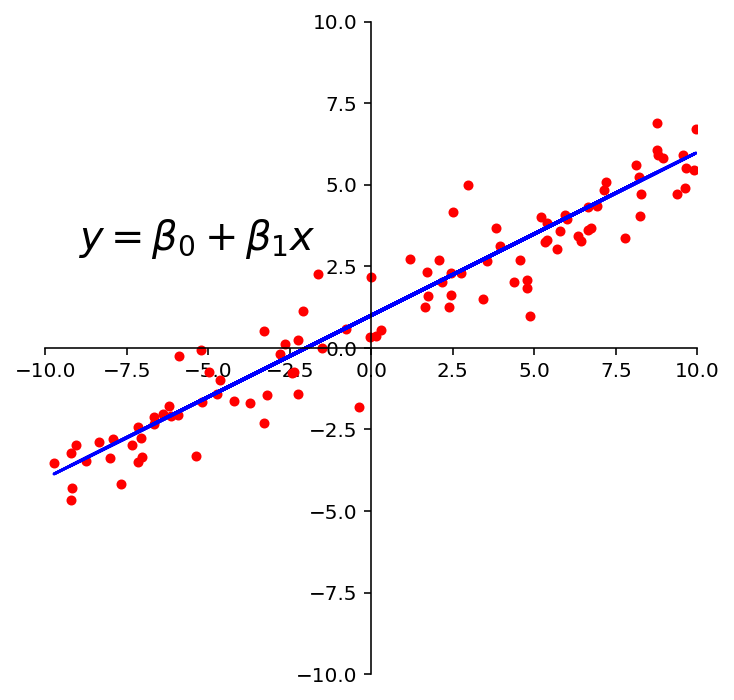

In [9]:
ax = plotSetup(-10,10,-10,10)
centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4)
ax.plot(xlin,line[0]+line[1]*xlin,'b-')
plt.text(-9,3,r'$y = \beta_0 + \beta_1x$',size=20);

Now, to obtain the least-squares line, we must find the least-squares solution to $x\vbt = y$.

From linear algebra we know that the least squares solution of $x\vbt = y$ is given by the solution of the __normal equations__:

$$x^Tx\vbt = x^Ty$$

We also know that the normal equations __always__ have at least one solution. And if $x^Tx$ is invertible, there is a unique solution that is given by:
    
$$\vbt = (x^Tx)^{-1} x^Ty$$

## General linear model

Another way that the inconsistent linear system is often written is to collect all the residuals into a __residual vector__. Then an exact equation is:

$$y = x\vbt + {\mathbf\epsilon}$$

Any equation of this form is referred to as a __linear model__. In this formulation, the goal is to find the $\beta$ so as to minimize the length of $\epsilon$, i.e, $\Vert\epsilon\Vert.$

In some cases, one would like to fit data points with something other than a straight line. In cases like this, the matrix equation is still $x\vbt = y$, but the specific form of $x$ changes from one problem to the next.

## Least-squares fitting of other models

Most models have parameters, and the objective of __model fitting__ is to to fix those parameters. In model fitting, the parameters are the unknown. A central question for us is whether the model is _linear_ in its parameters.

For example, the model $y = \beta_0 e^{-\beta_1 x}$ is __not__ linear in its parameters.  The model $y = \beta_0 e^{-2 x}$ __is__ linear in its parameters.

For a model that is linear in its parameters, an observation is a linear combination of (arbitrary) known functions.

In other words, a model that is linear in its parameters is

$$y = \beta_0f_0(x) + \beta_1f_1(x) + \dots + \beta_nf_n(x)$$

where $f_0, \dots, f_n$ are known functions and $\beta_0,\dots,\beta_k$ are parameters.

__Example:__  Suppose data points $(x_1, y_1), \dots, (x_n, y_n)$ appear to lie along some sort of parabola instead of a straight line.  Suppose we wish to approximate the data by an equation of the form

$$y = \beta_0 + \beta_1x + \beta_2x^2.$$

Describe the linear model that produces a "least squares fit" of the data by the equation.

__Solution.__  The ideal relationship is $y = \beta_0 + \beta_1x + \beta_2x^2.$

Suppose the actual values of the parameters are $\beta_0, \beta_1, \beta_2.$  Then the coordinates of the first data point satisfy the equation

$$y_1 = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \epsilon_1$$

where $\epsilon_1$ is the residual error between the observed value $y_1$ and the predicted $y$-value.

Each data point determines a similar equation:

$$y_1 = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \epsilon_1$$
$$y_2 = \beta_0 + \beta_1x_2 + \beta_2x_2^2 + \epsilon_2$$
$$\vdots$$
$$y_n = \beta_0 + \beta_1x_n + \beta_2x_n^2 + \epsilon_n$$

Clearly, this system can be written as $y = x\vbt + \mathbf{\epsilon}$.

$$\mat{{c}y_1\\y_2\\\vdots\\y_n} = \mat{{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_n&x_n^2} \mat{{ccc}\beta_0\\\beta_1\\\beta_2} + \mat{{c}\epsilon_1\\\epsilon_2\\\vdots\\\epsilon_n}$$

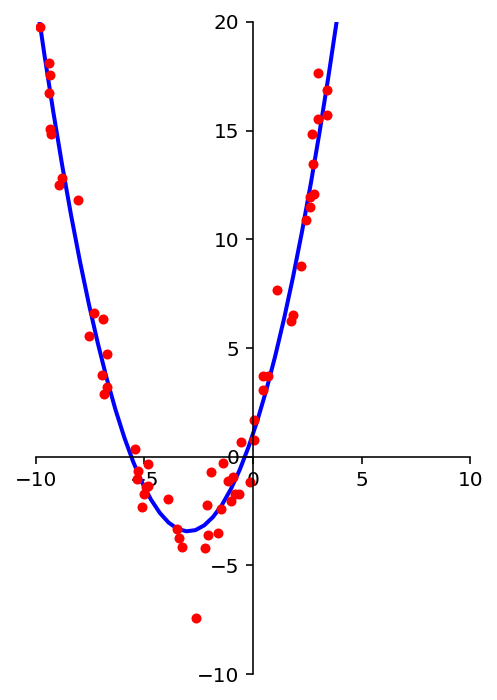

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#
# Input data are in the vectors xquad and yquad
#
# estimate the parameters of the linear model
#
m = np.shape(xquad)[0]
X = np.array([np.ones(m),xquad,xquad**2]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ yquad
#
# plot the results
#
ax = plotSetup(-10,10,-10,20)
centerAxes(ax)
xplot = np.linspace(-10,10,50)
yestplot = beta[0]+beta[1]*xplot+beta[2]*xplot**2
ax.plot(xplot,yestplot,'b-',lw=2)
ax.plot(xquad,yquad,'ro',markersize=4);

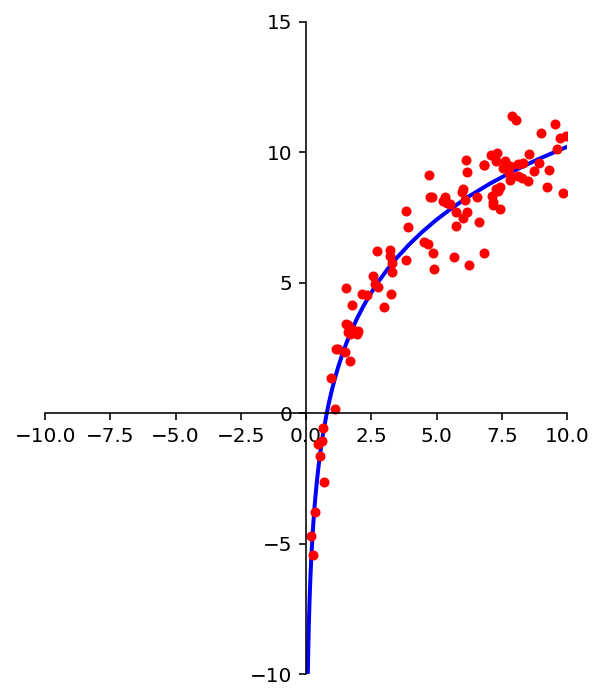

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#
# Input data are in the vectors xlog and ylog
#
# estimate the parameters of the linear model
#
m = np.shape(xlog)[0]
X = np.array([np.ones(m),np.log(xlog)]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ ylog
# 
# plot the results
#
ax = plotSetup(-10,10,-10,15)
centerAxes(ax)
xplot = np.logspace(np.log10(0.0001),1,100)
yestplot = beta[0]+beta[1]*np.log(xplot)
ax.plot(xplot,yestplot,'b-',lw=2)
ax.plot(xlog,ylog,'ro',markersize=4);

## Multiple regression

Suppose an experiment involves two independent variables -- say, $u$ and $v$, -- and one dependent variable, $y$.  A simple equation for predicting $y$ from $u$ and $v$ has the form

$$y = \beta_0 + \beta_1 u + \beta_2 v$$

Since there is more than one independent variable, this is called __multiple regression.__

A more general prediction equation might have the form

$$y = \beta_0 + \beta_1 u + \beta_2 v + \beta_3u^2 + \beta_4 uv + \beta_5 v^2$$

A least squares fit to equations like this is called a __trend surface.__

In general, a linear model will arise whenever $y$ is to be predicted by an equation of the form

$$y = \beta_0f_0(u,v) + \beta_1f_1(u,v) + \cdots + \beta_kf_k(u,v)$$

with $f_0,\dots,f_k$ any sort of known functions and $\beta_0,...,\beta_k$ unknown weights.

__Example.__  In geography, local models of terrain are constructed from data $(u_1, v_1, y_1), \dots, (u_n, v_n, y_n)$ where $u_j, v_j$, and $y_j$ are latitude, longitude, and altitude, respectively.

Let's describe the linear models that gives a least-squares fit to such data.  The solution is called the least-squares _plane._

__Solution.__  We expect the data to satisfy these equations:

$$y_1 = \beta_0 + \beta_1 u_1 + \beta_2 v_1 + \epsilon_1$$
$$y_2 = \beta_0 + \beta_1 u_2 + \beta_2 v_2 + \epsilon_2$$
$$\vdots$$
$$y_n = \beta_0 + \beta_1 u_n + \beta_2 v_n + \epsilon_n$$

This system has the matrix for $y = X\vbt + \epsilon,$ where

$$y = \mat{{c}y_1\\y_1\\\vdots\\y_n},\;\;X = \mat{{ccc}1&u_1&v_1\\1&u_2&v_2\\\vdots&\vdots&\vdots\\1&u_n&v_n},\;\;\vbt=\mat{{c}\beta_0\\\beta_1\\\beta_2},\;\;\epsilon = \mat{{c}\epsilon_1\\\epsilon_2\\\vdots\\\epsilon_n}$$

Note that the linear model for multiple regression has the same abstract form as the model for the simple regression in the earlier examples.

The normal equations for $\vbt$ have the same matrix form, no matter how many variables are involved.

Thus, for any linear model where $X^TX$ is invertible, the least squares estimate $\hat{\vbt}$ is given by $(X^TX)^{-1}X^T y$.